In [1]:
# all imports here
import networkx as nx
import matplotlib.pyplot as plt
import os
import json
import pandas as pd
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans



In [2]:
all_text_data = []


In [3]:
import numpy as np
vectorizer = CountVectorizer(min_df=5, max_features=1000)
def apply_keygraph(text_data):
    #CountVectorizer converts the text docs (tweets) into matrix of token counts
    # min_df = how many documents the term must be present in for it to be included in matrix
    #max_features = only top 1000 words will be considered 
    
    term_document_matrix = vectorizer.fit_transform(text_data).toarray()

    features = vectorizer.get_feature_names_out()
    print(features)
    G = nx.Graph()

    # Get term co-occurrences
    co_occurrences = (term_document_matrix.T @ term_document_matrix)
    for i, term1 in enumerate(features):
        if term1 not in stop_words and len(term1) > 2:
            for j, term2 in enumerate(features):
                if i < j  and len(term1) > 2 and len(term2) > 2:
                    weight = co_occurrences[i, j]
                    # If term1 and term2 appear together in the documents (i.e., weight > 0), 
                    # an edge is added between these terms in the graph G, with the co-occurrence frequency as the weight.
                    if weight > 0:   
                        G.add_edge(term1, term2, weight=weight)
        
    return G

In [4]:
stop_words = set(stopwords.words('english'))


def process_tweet(tweet):
    # Split the tweet into words
    words = str(tweet).split()
    
    # List comprehension to filter out stop words and short words
    filtered_words = [
        word for word in words 
        if word.lower() not in stop_words 
        and len(word) > 2 
        and not word.startswith('http')
    ]
    
    # Join the filtered words back into a string
    processed = ' '.join(filtered_words)
    
    return processed



In [6]:
 

base_directory = "CrisisLexT26-v1.0\CrisisLexT26"

text_data=pd.DataFrame()

for folder_name in os.listdir(base_directory):
    folder_path = os.path.join(base_directory, folder_name)
    if os.path.isdir(folder_path):
        json_file_path = os.path.join(folder_path, f"{folder_name}-event_description.json")
        
        #get event description. compare accuracy later
        with open(json_file_path, 'r', encoding='utf-8') as f:
            event_data = json.load(f)
        
        
        tweets_csv_path = os.path.join(folder_path, f"{folder_name}-tweets_labeled.csv")
                
        df = pd.read_csv(tweets_csv_path)
                
        # Filter relevant tweets
        text_data = text_data[text_data[' Informativeness'].isin(['Related - but not informative', 'Related and informative'])]

        text_data = df[' Tweet Text'].apply(process_tweet).values

        all_text_data.extend(text_data)

G = apply_keygraph(all_text_data)




KeyError: ' Informativeness'

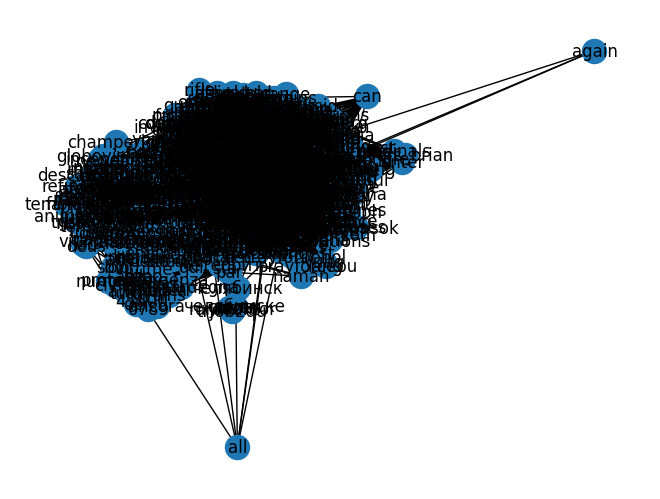

In [ ]:

pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True)
plt.show()

In [ ]:
def assign_topic_to_tweet(tweet, G):
    processed_tweet = vectorizer.transform([tweet])
    
    top_topics = []  # List to store top topics (term, neighbor) pairs
    
    # Extract the non-zero indices from the CSR matrix
    term_indices = processed_tweet.indices
    
    for term_index in term_indices:
        term = vectorizer.get_feature_names_out()[term_index]
        if term in G.nodes:
            neighbors = G[term]
            for neighbor, attributes in neighbors.items():
                weight = attributes.get('weight', 0)
                if len(top_topics) < 5 or weight > top_topics[-1][0]:
                    top_topics.append((weight, term, neighbor))
                    top_topics.sort(reverse=True)
                    top_topics = top_topics[:5]  # Keep only the top 5 topics
    
    return top_topics

top_topics = assign_topic_to_tweet("Denver Post: #Colorado governor signs bill creating rules for public access to ballots", G)

for weight, term, neighbor in top_topics:
    print(f"Weight: {weight}, Topic: {term} - {neighbor}")


Weight: 1150, Topic: colorado - http
Weight: 374, Topic: colorado - springs
Weight: 277, Topic: colorado - flooding
Weight: 270, Topic: colorado - fire
Weight: 238, Topic: colorado - floods


In [ ]:

stop_words = stopwords.words('english')
vectorizer = CountVectorizer(min_df=5, stop_words=stop_words)

text_vectorized = vectorizer.fit_transform(all_text_data)

lda = LatentDirichletAllocation(n_components=26)  # Choose the number of topics
lda.fit(text_vectorized)


LatentDirichletAllocation(n_components=26)

In [ ]:
feature_names = vectorizer.get_feature_names_out()

for index, topic in enumerate(lda.components_):
    print(f"Topic #{index + 1}")
    print([feature_names[i] for i in topic.argsort()[-10:]])


Topic #1
['earthquake', 'let', 'keep', 'everyone', 'bohol', 'stay', 'god', 'pray', 'prayforvisayas', 'safe']
Topic #2
['night', 'bigwet', 'police', 'pub', 'clutha', 'co', 'http', 'crash', 'glasgow', 'helicopter']
Topic #3
['emilia', 'week', 'rains', 'far', 'heavy', 'italia', 'non', 'che', 'prayfortexas', 'terremoto']
Topic #4
['olbia', 'non', 'della', 'allertameteosar', 'terremoto', 'alluvione', 'per', 'co', 'http', 'sardegna']
Topic #5
['floodph', 'habagat', 'maria', 'santa', 'boate', 'kiss', 'maringph', 'co', 'http', 'bigwet']
Topic #6
['via', 'hit', 'video', 'philippines', 'haiyan', 'russia', 'meteor', 'typhoon', 'co', 'http']
Topic #7
['new', 'california', 'metro', 'situation', 'tsarnaev', 'usa', 'russianmeteor', 'метеорит', 'flood', 'manila']
Topic #8
['hurts', 'south', 'zone', 'set', 'bush', 'australia', 'mph', 'fires', 'co', 'http']
Topic #9
['cross', 'sydney', 'nsw', 'red', 'gt', 'nswrfs', 'fire', 'nswfires', 'co', 'http']
Topic #10
['depth', '09', 'ago', '12', '10', '11', '201

In [ ]:
all_tweets_df = pd.DataFrame()


for folder_name in os.listdir(base_directory):
    folder_path = os.path.join(base_directory, folder_name)
    if os.path.isdir(folder_path):
        tweets_csv_path = os.path.join(folder_path, f"{folder_name}-tweets_labeled.csv")
        df = pd.read_csv(tweets_csv_path)
        
        # Removing stop words, words less than 3 characters
        df['Processed_Tweet'] = df[' Tweet Text'].apply(lambda x: ' '.join([word for word in x.split() if (word.lower() not in stop_words and len(word) > 2)]))
        
        df['Topic'] = folder_name

        all_tweets_df = pd.concat([all_tweets_df, df], ignore_index=True)

        all_tweets_df = all_tweets_df[all_tweets_df[' Informativeness'].isin(['Related - but not informative', 'Related and informative'])]


In [ ]:
print(all_tweets_df[' Informativeness'].unique())


['Related and informative' 'Related - but not informative']


In [ ]:
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score



all_text_data = all_tweets_df['Processed_Tweet'].values
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(all_text_data)

# Perform K-means clustering
n_clusters = 26  
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X)
predicted_labels = kmeans.fit_predict(X)
labels = all_tweets_df['Topic']

ari = adjusted_rand_score(labels, predicted_labels)
nmi = normalized_mutual_info_score(labels, predicted_labels)
silhouette = silhouette_score(X, predicted_labels)

all_tweets_df['Cluster_Label'] = kmeans.labels_






c:\Users\Thania\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.19292187696173435
Normalized Mutual Information: 0.6342184465822727
Silhouette Score: 0.019971078406886528


In [ ]:
print(f'Adjusted Rand Index: {ari}')
print(f'Normalized Mutual Information: {nmi}')
print(f'Silhouette Score: {silhouette}')

[21  9 16 ...  5 21  5]


In [ ]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

base_directory = 'CrisisLexT26-v1.0\CrisisLexT26'  # Update with the path of your directory
stop_words = set()  # Update with your list/set of stop words if you have any

all_tweets_df = pd.DataFrame()

# Load tweets from the folder structure and preprocess
for folder_name in os.listdir(base_directory):
    folder_path = os.path.join(base_directory, folder_name)
    if os.path.isdir(folder_path):
        tweets_csv_path = os.path.join(folder_path, f"{folder_name}-tweets_labeled.csv")
        
        if os.path.exists(tweets_csv_path):  # Check if file exists before loading
            df = pd.read_csv(tweets_csv_path)
            
            # Remove stop words and words with less than 3 characters
            df['Processed_Tweet'] = df[' Tweet Text'].apply(lambda x: ' '.join([word for word in str(x).split() if (word.lower() not in stop_words and len(word) > 2)]))
            
            df['Topic'] = folder_name
            all_tweets_df = pd.concat([all_tweets_df, df], ignore_index=True)

# Filter relevant tweets
all_tweets_df = all_tweets_df[all_tweets_df[' Informativeness'].isin(['Related - but not informative', 'Related and informative'])]

# Perform clustering with KMeans
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(all_tweets_df['Processed_Tweet'].values)

n_clusters = 26  
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
all_tweets_df['predicted_label'] = kmeans.labels_

label_map = {}
for cluster_num in range(n_clusters):
    mode_label = all_tweets_df[all_tweets_df['predicted_label'] == cluster_num]['Topic'].mode()[0]
    label_map[cluster_num] = mode_label

all_tweets_df['predicted_label'] = all_tweets_df['predicted_label'].map(label_map)

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(all_tweets_df['Topic'], all_tweets_df['predicted_label'])
print(f"Accuracy: {accuracy*100:.2f}%")
# Assign cluster labels to DataFrame
all_tweets_df['Cluster_Label'] = kmeans.labels_




c:\Users\Thania\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Accuracy: 55.11%
Adjusted Rand Index: 0.2566668354944997


In [ ]:
# Compute evaluation metrics
ari = adjusted_rand_score(all_tweets_df['Topic'], all_tweets_df['Cluster_Label'])
nmi = normalized_mutual_info_score(all_tweets_df['Topic'], all_tweets_df['Cluster_Label'])
silhouette = silhouette_score(X, all_tweets_df['Cluster_Label'])

print(f'Adjusted Rand Index: {ari}')

print(f'Normalized Mutual Information: {nmi}')

print(f'Silhouette Score: {silhouette}')



Adjusted Rand Index: 0.2566668354944997
Normalized Mutual Information: 0.6266514178724826
Silhouette Score: 0.016411412218512965


In [ ]:
import gensim

# Load Google's pre-trained Word2Vec model

def tweet_to_vector(tweet, model):
    vector_list = [model[word] for word in tweet if word in model.wv]
    if len(vector_list) == 0:
        return np.zeros(model.vector_size)
    vector = np.mean(vector_list, axis=0)
    return vector

all_tweets_df['vector'] = all_tweets_df['tokenized_tweet'].apply(lambda x: tweet_to_vector(x, model))


import gensim

# Load Google's pre-trained Word2Vec model
model = gensim.models.KeyedVectors.load_word2vec_format('path_to/GoogleNews-vectors-negative300.bin', binary=True)
all_tweets_df['predicted_label'] = kmeans.labels_

label_map = {}
for cluster_num in range(n_clusters):
    mode_label = all_tweets_df[all_tweets_df['predicted_label'] == cluster_num]['Topic'].mode()[0]
    label_map[cluster_num] = mode_label

all_tweets_df['predicted_label'] = all_tweets_df['predicted_label'].map(label_map)

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(all_tweets_df['Topic'], all_tweets_df['predicted_label'])
print(f"Accuracy: {accuracy*100:.2f}%")



FileNotFoundError: [Errno 2] No such file or directory: 'path_to/GoogleNews-vectors-negative300.bin'